# Using ICA to reduce artefacts

This section will demonstrate how to use an independent component analysis (ICA) approach to suppress ocular and cardiac artefacts. First, the data will be decomposed using ICA, after which the components reflecting the artefacts will be identified manually. As a last step, the artefact components will be 'projected out'.

## Preparation
### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from mne_bids import (
    BIDSPath,
    read_raw_bids
)
from mne.preprocessing import ICA
from IPython.display import Image, display

### File overview

The chapter relies on the file (embedded in the BIDS structure):

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif

and generates the output files:

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica_raw.fif


The filtered data is saved in the derivative folder of the BIDS Directory. 


Specify the BIDS parameters along with the path to the BIDS folder:

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'hfc_raw'
ann_suffix = 'ann_raw'
ica_suffix ='ica_raw'

# data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=ann_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(ann_suffix, ica_suffix) # fif output filename
deriv_fname_fif = op.join(bids_path.directory, deriv_fname)

print(bids_path)
print(deriv_fname_fif)

/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif
/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica_raw.fif



## Resampling and filtering of the raw data

To make the ICA algorithm operate more efficiently, the data will be downsampled. The version of the dataset that has already been cleaned using homogeneous field correction and has annotations will be used. This data will be resampled to 250 Hz, and then a bandpass filter between 1 and 40 Hz will be applied. The high-pass filter at 1 Hz is especially important as it removes slow drifts in the signal, which can otherwise make ICA less effective.

Note that the ICA projection eventually will be applied to the raw data sampled as 1500 Hz; i.e. the down-sampling applied is only temporary.


In [3]:
# Read the raw data from the BIDS path
raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)

# Process the raw data
raw_resmpl = raw.copy().pick('mag')  
raw_resmpl.filter(3, 30)  
raw_resmpl.resample(250)  


Opening raw data file /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/2274475918.py:2: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/2274475918.py:2: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/2274475918.py:2: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1239 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.7s


<Raw | sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif, 180 x 513269 (2053.1 s), ~710.5 MiB, data loaded>


## Applying the ICA algorithm

Now,the ICA algorithm will be applied. The **fastICA** algorithm is chosen as it is well-established and widely used. However, other ICA methods are available in MNE-Python. To expedite the computation, a Principal Component Analysis is used to reduce the data to 30 dimensions. 


In [4]:
raw_resmpl_all = raw_resmpl
ica = ICA(method='fastica',
    random_state=96,
    n_components=30,
    verbose=False)

ica.fit(raw_resmpl_all,
    verbose=False,
       picks='meg')

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,59 iterations on raw data (507569 samples)
ICA components,30
Available PCA components,180
Channel types,mag
ICA components marked for exclusion,—



## Identifying the ICA components reflecting the artefacts

To plot the examples for the time-traces of the ICA components use:


In [5]:
%matplotlib inline
ica.plot_sources(raw_resmpl_all, title='ICA');

    Applying projection operator with 8 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=30, n_times=513269
    Range : 0 ... 513268 =      0.000 ...  2053.072 secs
Ready.
Using qt as 2D backend.
Using pyopengl with version 3.1.6


/Users/o.jensen@bham.ac.uk/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


This script will open an interactive session. Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components. 

Please see an example below. 

In [6]:
image_url = 'https://github.com/FLUX-pipeline/Cerca/blob/main/ICAexample.png?raw=true'
display(Image(url=image_url))

From this example, it is clear that ICA component 6 reflects eye blinks. It is also evident that component 18 reflects cardiac artefacts, as the QRS complex is clearly visible with a rate of about 1 Hz.  

Note that the order of the components can change depending on the hardware used (the components 6 and 18 were observed in a Mac, whereas as Microsoft PC produced the components 6 and 11)

**Question 1:** Muscular artefacts do not seem to collected in a single ICA component. Why might that be?


## Attenuating ocular and cardiac artefacts by applying the projections

Now the ICA components associated with ocular and cardiac artefacts are detected, hence it must be 'projected out'. This will be done by applying the ICA projections generated by ica.exclude to the original raw data, which will be loaded again. After the ICA projections have been applied *(ica.apply)* the data will be saved.

In [7]:
# Set the 2 components to exclude
ica.exclude = [6,11]

raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
ica.apply(raw_ica)

raw_ica.save(deriv_fname_fif, overwrite=True)

Opening raw data file /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...
Applying ICA to Raw instance


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/625699223.py:4: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/625699223.py:4: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_75707/625699223.py:4: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01

    Applying projection operator with 8 vectors (pre-whitener application)
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 180 PCA components
Writing /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica_raw.fif
Closing /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica_raw.fif
[done]


[PosixPath('/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica_raw.fif')]


## Plotting the data to check the artefact reduction

We will here examine some of the traces to demonstrate the artefact reduction.

Define a few frontal OPM sensors to examine

For the sake of understanding sensor-positions will be plotted in a topographic representation

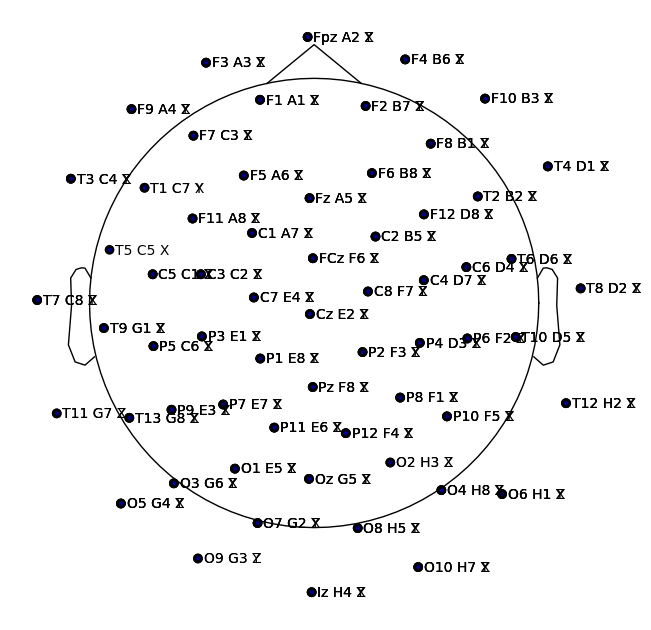

In [8]:
raw_ica.plot_sensors(kind='topomap', show_names=True);

Frontal sensors 'F9 A4 Z' happens to be sensitive to eye-blicks. 

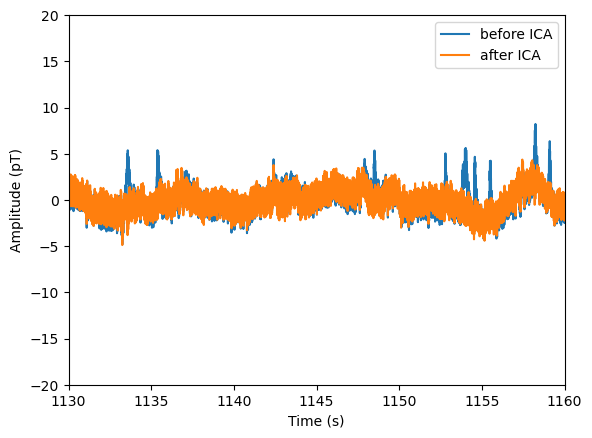

In [9]:
picks = mne.pick_types(raw.info, include=['F9 A4 Z'])

amp_scale = 1e12  # Converting to pico Tesla(pT)

data_ds, time_ds = raw[picks]
dataICA_ds, timeICA_ds = raw_ica[picks]

plt.plot(time_ds, amp_scale*data_ds.T,label='before ICA')
plt.plot(timeICA_ds, amp_scale*dataICA_ds.T,label='after ICA');
plt.legend()
plt.xlim(1130, 1160)
plt.ylim(-20, 20)

plt.xlabel('Time (s)'); 
plt.ylabel('Amplitude (pT)');

In the plot above, it is clear the ICA serve to effectively reduce the eye-blink artefacts. 

## Preregistration and Publication

Example text:
"The data were down sampled to 250 Hz prior to Independent Component Analysis (ICA) and bandpass filtered at 1 – 40 Hz. Next the fastICA algorithm (`Hyvärinen and Oja, 2000`) was applied to the segmented data as implemented in MNE Python. Components containing cardiac artefacts and eyeblinks (identified in time course and topographies of the ICA components) were removed in each subject (2 – 5 over subjects) in the raw  data. "


## References

[Hyvärinen & Oja, 2002]: Hyvärinen, A., & Oja, E. (2002). Independent component analysis: algorithms and applications. *Neural Networks*, 13(4–5), 411–430. https://doi.org/10.1016/s0893-6080(00)00026-5


